In [1]:
import onnx
from onnx import helper
from onnx import TensorProto
 
def delete_add_node(nodes):
    new_nodes = []
    for node in nodes:
        if node.name == "conv":
            new_scale_node = onnx.helper.make_node(
                "Conv",
                inputs=['conv_input','conv_weight','conv_bias'],
                outputs=['output'],
                name="conv"
            )
            new_nodes += [new_scale_node]
        elif node.name =='add':
            continue
        else:
            new_nodes += [node]
 
    return new_nodes
 
if __name__=='__main__':
    model = onnx.load('resize_conv_add.onnx')
    graph = model.graph
    nodes = graph.node
    opset_version = model.opset_import[0].version
 
    graph_name = f"{graph.name}-int32"
    new_nodes = delete_add_node(nodes)
    graph_int32 = helper.make_graph(
        new_nodes,
        graph_name,
        graph.input[:-1],  # 删除Add节点的输入向量
        graph.output,
        initializer=graph.initializer,
    )
 
    model_int32 = helper.make_model(graph_int32, producer_name="onnx-typecast")
    model_int32.opset_import[0].version = opset_version
    onnx.checker.check_model(model_int32)
    onnx.save_model(model_int32, "delete_add.onnx")

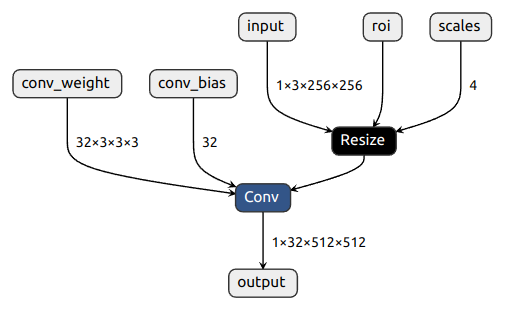